In [1]:
from os import chdir
chdir("/l/hegdep1/onoffgp/triton")

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from onofftf.main import Variable, Param, DataSet, GaussKL, GPConditional, KernSE
from onofftf.plot_pptr import plot_pptr,plot_ind
from onofftf.utils import modelmanager
from onofftf.utils_pptr import preprocessing

from gpflow import transforms
from scipy.cluster.vq import kmeans

float_type = tf.float64
jitter_level = 1e-6

In [3]:
import pandas as pd
raw_data = pd.read_pickle(open("data/pptrdata2017-2.pickle","rb"))

pro_data = preprocessing(raw_data)
pro_data.filter_time(4368,5447) #6020,6060

print("number of training and test examples:",pro_data.shape)

Xtrain = pro_data.data['filt']['Xtrain']
Ytrain = pro_data.data['filt']['Ytrain']

Xtest = pro_data.data['filt']['Xtest']
Ytest = pro_data.data['filt']['Ytest']

number of training and test examples: ((105280, 3), (7735, 3))


In [4]:
train_data = DataSet(Xtrain,Ytrain)

**parameter initializations**

In [5]:
list_to_np = lambda _list : [np.array(e) for e in _list]

num_iter = 30000
num_inducing_f = np.array([10,100])
num_inducing_g = np.array([10,100])
num_data = Xtrain.shape[0]
num_minibatch = 500

init_fkell = list_to_np([[8.,8.],[5./1000]])
init_fkvar = list_to_np([[20.],[20.]])

init_gkell = list_to_np([[8.,8.],[5./1000]])
init_gkvar = list_to_np([[10.],[10.]])

init_noisevar = 0.001

q_diag = True
# init_f_mu = 0.

init_Zf_s = kmeans(Xtrain[:,0:2],num_inducing_f[0])[0]
init_Zf_t = np.expand_dims(np.linspace(Xtrain[:,2].min(),Xtrain[:,2].max(),num_inducing_f[1]),axis=1)

init_Zf = [init_Zf_s,init_Zf_t]
init_Zg = init_Zf.copy()


init_u_fm = np.random.randn(np.prod(num_inducing_f),1)*0.1
init_u_gm = np.random.randn(np.prod(num_inducing_g),1)*0.1

init_u_fs_sqrt = np.ones(np.prod(num_inducing_f)).reshape(1,-1).T
init_u_gs_sqrt = np.ones(np.prod(num_inducing_g)).reshape(1,-1).T

kern_param_learning_rate = 1e-4
indp_param_learning_rate = 1e-4

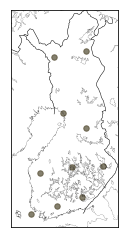

In [6]:
plot_ind(init_Zf_s[:,0],init_Zf_s[:,1])

**declare tensorflow variables and placeholders**

In [7]:
X = tf.placeholder(dtype = float_type)
Y = tf.placeholder(dtype = float_type)

with tf.name_scope("f_kern"):
    fkell = [Param(init_fkell[i],transform=transforms.Log1pe(),
                   name="lengthscale",learning_rate = kern_param_learning_rate,summ=True)
             for i in range(len(num_inducing_f))]

    fkvar = [Param(init_fkvar[i],transform=transforms.Log1pe(),
                   name="variance",learning_rate = kern_param_learning_rate,summ=True)
             for i in range(len(num_inducing_f))]

fkern_list = [KernSE(fkell[i],fkvar[i]) for i in range(len(num_inducing_f))]

with tf.name_scope("g_kern"):
    gkell = [Param(init_gkell[i],transform=transforms.Log1pe(),
                   name="lengthscale",learning_rate = kern_param_learning_rate,summ=True)
             for i in range(len(num_inducing_g))]

    gkvar = [Param(init_gkvar[i],transform=transforms.Log1pe(),
                   name="variance",learning_rate = kern_param_learning_rate,summ=True)
             for i in range(len(num_inducing_g))]

gkern_list = [KernSE(gkell[i],gkvar[i]) for i in range(len(num_inducing_g))]

with tf.name_scope("likelihood"):
    noisevar = Param(init_noisevar,transform=transforms.Log1pe(),
                     name="variance",learning_rate = kern_param_learning_rate,summ=True)


with tf.name_scope("f_ind"):
    Zf_list = [Param(init_Zf[i],name="z",learning_rate = indp_param_learning_rate,summ=True)
               for i in range(len(num_inducing_f))]
    
    u_fm = Param(init_u_fm,name="value",learning_rate = indp_param_learning_rate,summ=True)
    if q_diag:
        u_fs_sqrt = Param(init_u_fs_sqrt,transforms.positive,
                          name="variance",learning_rate = indp_param_learning_rate,summ=True)
    else:
        u_fs_sqrt = Param(init_u_fs_sqrt,transforms.LowerTriangular(init_u_fs_sqrt.shape[0]),
                          name="variance",learning_rate = indp_param_learning_rate,summ=True)
    
#     f_mu = Param(init_f_mu,name="fmu",learning_rate = indp_param_learning_rate,summ=True)

with tf.name_scope("g_ind"):
    Zg_list = [Param(init_Zg[i],name="z",learning_rate = indp_param_learning_rate,summ=True)
               for i in range(len(num_inducing_g))]

    u_gm = Param(init_u_gm,name="value",learning_rate = indp_param_learning_rate,summ=True)
    if q_diag:
        u_gs_sqrt = Param(init_u_gs_sqrt,transforms.positive,
                          name="variance",learning_rate = indp_param_learning_rate,summ=True) 
    else:
        u_gs_sqrt = Param(init_u_gs_sqrt,transforms.LowerTriangular(init_u_gs_sqrt.shape[0]),
                          name="variance",learning_rate = indp_param_learning_rate,summ=True)

** define prior kl divergence, variational expectations and predict functions **

In [8]:
def build_prior_kl(u_fm,u_fs_sqrt,fkern_list,Zf_list,
                   u_gm,u_gs_sqrt,gkern_list,Zg_list,whiten=False):
    if whiten:
       raise NotImplementedError()
    else:
        Kfmm = [fkern_list[i].K(Zf_list[i].get_tfv()) + \
                tf.eye(num_inducing_f[i], dtype=float_type) * jitter_level
                for i in range(len(num_inducing_f))]
        
        Kgmm = [gkern_list[i].K(Zg_list[i].get_tfv()) + \
                tf.eye(num_inducing_g[i], dtype=float_type) * jitter_level
                for i in range(len(num_inducing_g))]

        Kfmm_expanded = tf_kron(Kfmm[0],Kfmm[1])
        Kgmm_expanded = tf_kron(Kgmm[0],Kgmm[1])

        KL = GaussKL(u_fm.get_tfv(), u_fs_sqrt.get_tfv(), Kfmm_expanded) + \
             GaussKL(u_gm.get_tfv(), u_gs_sqrt.get_tfv(), Kgmm_expanded)

    return KL


def build_predict(Xnew,u_fm,u_fs_sqrt,fkern_list,Zf_list,u_gm,u_gs_sqrt,gkern_list,Zg_list,f_mu=None):

    input_mask_f = _gen_inp_mask(Zf_list)
    input_mask_g = _gen_inp_mask(Zg_list)

    # compute fmean and fvar from the kronecker inference
    fmean,fvar = kron_inf(Xnew,fkern_list,Zf_list,u_fm,u_fs_sqrt,num_inducing_f,input_mask_f)
    # fmean = fmean + mean_function(Xnew)
    if not f_mu is None :
        fmean = fmean + f_mu.get_tfv()


    # compute gmean and gvar from the kronecker inference
    gmean,gvar = kron_inf(Xnew,gkern_list,Zg_list,u_gm,u_gs_sqrt,num_inducing_g,input_mask_g)

    # compute augemented distributions
    ephi_g, ephi2_g, evar_phi_g = probit_expectations(gmean, gvar)

    # compute augmented f
    # p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
    gfmean = tf.multiply(ephi_g, fmean)
    gfvar = tf.multiply(ephi2_g, fvar)
    gfmeanu = tf.multiply(evar_phi_g, tf.square(fmean))

    # return mean and variance vectors in order
    return gfmean, gfvar, gfmeanu, fmean, fvar, gmean, gvar, ephi_g, evar_phi_g


def kron_inf(Xnew,kern_list,Z_list,q_mu,q_sqrt,num_inducing,input_mask):
    # Compute alpha = K_mm^-1 * f_m
    Kmm = [kern_list[p].K(Z_list[p].get_tfv()) + \
           tf.eye(num_inducing[p], dtype=float_type) * jitter_level
           for p in range(len(num_inducing))]
    
    Kmm_inv = [tf.matrix_inverse(Kmm[p]) for p in range(len(num_inducing))]
    alpha = __kron_mv(Kmm_inv,q_mu.get_tfv(),num_inducing)

    n_batch = tf.stack([tf.shape(Xnew)[0],np.int32(1)])
    Knn = tf.ones(n_batch, dtype=float_type)
    KMN = []

    for p in range(len(num_inducing)):
        xnew = tf.gather(Xnew, input_mask[p], axis=1)
        Knn *= tf.reshape(kern_list[p].Kdiag(xnew), n_batch)
        KMN.append(kern_list[p].K(Z_list[p].get_tfv(), xnew))

    S = tf.diag(tf.squeeze(tf.square(q_sqrt.get_tfv())))

    def loop_rows(n,mu,var):
        Kmn = tf.reshape(KMN[0][:,n], [num_inducing[0],1])
        for p in range(1,len(num_inducing)):
            Kmn = tf_kron(Kmn,tf.reshape(KMN[p][:,n],[num_inducing[p],1]))

        mu_n = tf.matmul(Kmn, alpha, transpose_a=True)
        mu = mu.write(n, mu_n)
        A = __kron_mv(Kmm_inv,Kmn,num_inducing)
        tmp = Knn[n] - tf.matmul(Kmn, A,transpose_a=True) + \
                       tf.matmul(tf.matmul(A,S,transpose_a=True),A)

        var = var.write(n, tmp)
        return tf.add(n,1), mu, var

    def loop_cond(n,mu,var):
        return tf.less(n, n_batch[0])

    mu = tf.TensorArray(float_type, size=n_batch[0])
    var = tf.TensorArray(float_type, size=n_batch[0])
    _, mu, var = tf.while_loop(loop_cond, loop_rows, [0, mu, var])

    mu = tf.reshape(mu.stack(), n_batch)
    var = tf.reshape(var.stack(), n_batch)

    return mu , var

def __kron_mv( As, x,num_inducing):
    N = np.prod(num_inducing)
    b = tf.reshape(x, [N,1])
    for p in range(len(As)):
        Ap = As[p]
        X = tf.reshape(b, (num_inducing[p],
                           np.round(N/num_inducing[p]).astype(np.int)))
        b = tf.matmul(X, Ap, transpose_a=True, transpose_b=True)
        b = tf.reshape(b, [N,1])
    return b

def tf_kron(a,b):
    a_shape = [a.shape[0].value,a.shape[1].value]
    b_shape = [b.shape[0].value,b.shape[1].value]
    return tf.reshape(tf.reshape(a,[a_shape[0],1,a_shape[1],1])* \
                      tf.reshape(b,[1,b_shape[0],1,b_shape[1]]),
                      [a_shape[0]*b_shape[0],a_shape[1]*b_shape[1]])

def _gen_inp_mask(Z_list):
    input_mask = []
    tmp = 0
    for p in range(len(Z_list)):
        p_dim = Z_list[p].shape[1]
        input_mask.append(np.arange(tmp, tmp + p_dim, dtype=np.int32))
        tmp += p_dim
    return input_mask


def variational_expectations(Y,fmu,fvar,fmuvar,noisevar):
    return -0.5 * np.log(2 * np.pi) - 0.5 * tf.log(noisevar) \
            - 0.5 * (tf.square(Y - fmu) + fvar + fmuvar) / noisevar

def probit_expectations(gmean, gvar):
    def normcdf(x):
        return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

    def owent(h, a):
        h = tf.abs(h)
        term1 = tf.atan(a) / (2 * np.pi)
        term2 = tf.exp((-1 / 2) * (tf.multiply(tf.square(h), (tf.square(a) + 1))))
        return tf.multiply(term1, term2)

    z = gmean / tf.sqrt(1. + gvar)
    a = 1 / tf.sqrt(1. + (2 * gvar))

    cdfz = normcdf(z)
    tz = owent(z, a)

    ephig = cdfz
    ephisqg = (cdfz - 2. * tz)
    evarphig = (cdfz - 2. * tz - tf.square(cdfz))

    # clip negative values from variance terms to zero
    ephisqg = (ephisqg + tf.abs(ephisqg)) / 2.
    evarphig = (evarphig + tf.abs(evarphig)) / 2.

    return ephig, ephisqg, evarphig


** build model and define lower bound**

In [9]:
with tf.name_scope("kl"):
    kl = build_prior_kl(u_fm,u_fs_sqrt,fkern_list,Zf_list,
                        u_fm,u_fs_sqrt,fkern_list,Zf_list)
    tf.summary.scalar('kl', kl)

# get augmented functions
with tf.name_scope("model_build"):
    gfmean, gfvar, gfmeanu, fmean, fvar, gmean, gvar, ephi_g, evar_phi_g = build_predict(X,u_fm,u_fs_sqrt,fkern_list,Zf_list,
                                                                                           u_gm,u_gs_sqrt,gkern_list,Zg_list)
    tf.summary.histogram('gfmean',gfmean)

# compute likelihood
with tf.name_scope("var_exp"):
    var_exp = tf.reduce_sum(variational_expectations(Y,gfmean,gfvar,gfmeanu,noisevar.get_tfv()))
    tf.summary.scalar('var_exp', var_exp)

    # mini-batch scaling
    scale =  tf.cast(num_data, float_type) / tf.cast(num_minibatch, float_type)
    var_exp_scaled = var_exp * scale
    tf.summary.scalar('var_exp_scaled', var_exp_scaled)


# final lower bound
with tf.name_scope("cost"):
    cost =  -(var_exp_scaled - kl)
    tf.summary.scalar('cost',cost)


**load model**

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
modelmngr = modelmanager(saver, sess, "models/run_cores12_hr72_scaled_zt_4/run01/model.ckpt")
modelmngr.load()

INFO:tensorflow:Restoring parameters from models/run_cores12_hr72_scaled_zt_4/run01/model.ckpt
model loaded from : models/run_cores12_hr72_scaled_zt_4/run01/model.ckpt


** kernel parameters **

In [11]:
print("Noise variance          = ",noisevar.get_tfv().eval())
print("Kf spatial lengthscale  = ",fkell[0].get_tfv().eval())
print("Kf spatial variance     = ",fkvar[0].get_tfv().eval())
print("Kf temporal lengthscale = ",fkell[1].get_tfv().eval())
print("Kf temporal variance    = ",fkvar[1].get_tfv().eval())
# print("f mean                  = " ,f_mu.get_tfv().eval())

print("Kg spatial lengthscale  = ",gkell[0].get_tfv().eval())
print("Kg spatial variance     = ",gkvar[0].get_tfv().eval())
print("Kg temporal lengthscale = ",gkell[1].get_tfv().eval())
print("Kg temporal variance    = ",gkvar[1].get_tfv().eval())

Noise variance          =  0.347269289956
Kf spatial lengthscale  =  [ 6.30150255  7.86755836]
Kf spatial variance     =  [ 6.82348347]
Kf temporal lengthscale =  [ 0.0134673]
Kf temporal variance    =  [ 5.2157587]
Kg spatial lengthscale  =  [ 2.95497867  4.85107263]
Kg spatial variance     =  [ 4.4661758]
Kg temporal lengthscale =  [ 0.00827489]
Kg temporal variance    =  [ 1.15301072]


** visualizing learned parameters **

In [12]:
lp_u_fm = u_fm.get_tfv().eval().flatten()
lp_u_gm = u_gm.get_tfv().eval().flatten()

lp_zf_t = Zf_list[1].get_tfv().eval().flatten()
lp_zg_t = Zg_list[1].get_tfv().eval().flatten()

lp_zf_s = Zf_list[0].get_tfv().eval()
lp_zg_s = Zg_list[0].get_tfv().eval()


lp_zf_sort_ind = np.argsort(lp_zf_t)
lp_zg_sort_ind = np.argsort(lp_zg_t)

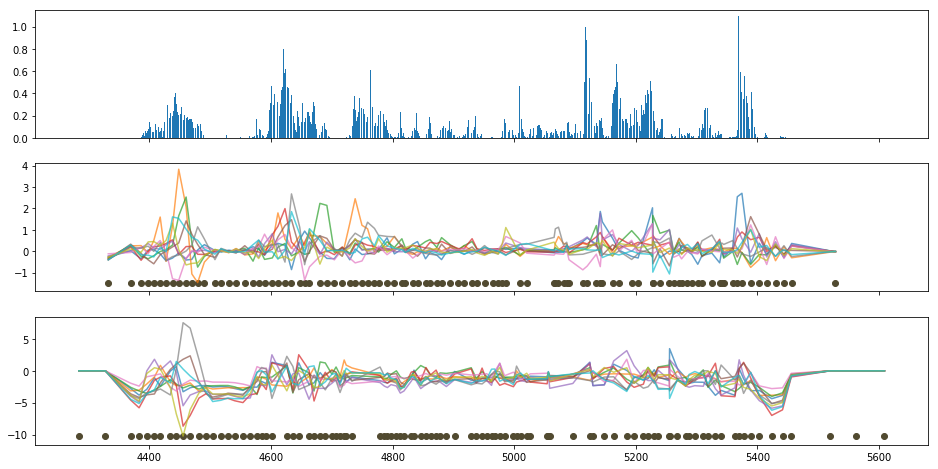

In [13]:
scale_z = 1000


mpl.rcParams['figure.figsize'] = (16,8)
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)

mean_pptr = pro_data.data['filt']['traindf'].groupby('ndatehour')['pptr'].mean()
ax1.bar(mean_pptr.index, mean_pptr.values, align='center')

for m in np.arange(num_inducing_f[0]):
    u_fm_temporal = lp_u_fm[m*num_inducing_f[1]:(m+1)*num_inducing_f[1]]
    ax2.plot(np.round(lp_zf_t[lp_zf_sort_ind] * scale_z,4),u_fm_temporal[lp_zf_sort_ind],alpha=0.7)
ax2.scatter(np.round(lp_zf_t[lp_zf_sort_ind] * scale_z,4),np.ones([num_inducing_f[1],1])*lp_u_fm.min(),color="#514A30")

for m in np.arange(num_inducing_g[0]):
    u_gm_temporal = lp_u_gm[m*num_inducing_g[1]:(m+1)*num_inducing_g[1]]
    ax3.plot(np.round(lp_zg_t[lp_zg_sort_ind] * scale_z,4),u_gm_temporal[lp_zg_sort_ind],alpha=0.7)
ax3.scatter(np.round(lp_zg_t[lp_zg_sort_ind] * scale_z,4),np.ones([num_inducing_g[1],1])*lp_u_gm.min(),color="#514A30")

plt.show()

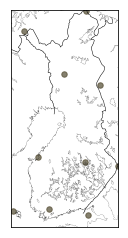

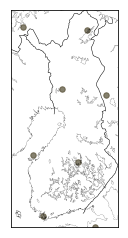

In [14]:
plot_ind(lp_zf_s[:,0],lp_zf_s[:,1])
plot_ind(lp_zg_s[:,0],lp_zg_s[:,1])

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from copy import deepcopy
import matplotlib.gridspec as gridspec
import matplotlib as mpl

def plot_pptr(Xplot,Yplot,gfmean,gfmeanu,gfvar,fmean,fvar,gmean,gvar,ephi_g,evar_phi_g):

    mpl.rcParams['figure.figsize'] = (16,8)
    
    Xplot[:,2] = Xplot[:,2]/scale_z
    ngrid = 100
    timevalue = Xplot[0,2]


    # create basemap instance
    pmap = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=65.0, lon_0=25.0,
            llcrnrlon=19.08, llcrnrlat= 59.45, urcrnrlon=31.59, urcrnrlat=70.09)

    xco = []
    yco =[]
    for lat,lon in Xplot[:,:2]:
        x, y = pmap(lon,lat)
        xco.append(x);yco.append(y)

    # prediction on test data
    pgfmean = gfmean.eval({X:Xplot})

    # prediction on grid data
    lonsgrid,latsgrid = pmap.makegrid(ngrid,ngrid)
    xgrid, ygrid = pmap(lonsgrid, latsgrid)
    griddata = np.array([latsgrid.flatten(),
                         lonsgrid.flatten(),
                         np.repeat(timevalue,ngrid*ngrid)])
    griddata = griddata.T

    tgfmean = gfmean.eval({X:griddata})
    tgfmean2 = gfmeanu.eval({X:griddata})
    tgfvar = gfvar.eval({X:griddata})
    tfmean = fmean.eval({X:griddata})
    tfvar = fvar.eval({X:griddata})
    tgmean = gmean.eval({X:griddata})
    tgvar = gvar.eval({X:griddata})
    tpgmean = ephi_g.eval({X:griddata})
    tpgvar = evar_phi_g.eval({X:griddata})

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 7)

    # plot 01 : actual data
    ax1 = fig.add_subplot(gs[0:2,0:2])
    p1 = deepcopy(pmap)
    p1.drawcountries(linewidth=0.8)
    p1.drawcoastlines(linewidth=0.4,linestyle="--")
    p1.scatter(xco,yco,c=Yplot.flatten(),alpha=0.7,s=40, marker='o')
    p1.colorbar(extend='max')
    ax1.set_title("data")


    # plot 02: model prediction
    ax2 = fig.add_subplot(gs[0:2,2:4])
    p2 = deepcopy(pmap)
    p2.drawcountries(linewidth=0.8)
    p2.drawcoastlines(linewidth=0.4,linestyle="--")
    p2.scatter(xco,yco,c=pgfmean.flatten(),alpha=0.7,s=40, marker='o')
    p2.colorbar(extend='max')
    ax2.set_title("augmented mean prediction")



    # plot 03
    ax3 = fig.add_subplot(gs[0,4])
    p3 = deepcopy(pmap)
    p3.drawcountries(linewidth=0.4)
    p3.drawcoastlines(linewidth=0.2,linestyle="--")
    # p3.scatter(xco,yco,c=pgfmean.tolist(),alpha=1,s=30, marker='o')
    p3.contourf(xgrid,ygrid,tfmean.reshape(ngrid,ngrid),cmap='RdYlGn',alpha=0.5)
    p3.colorbar(extend='max')
    ax3.set_title("f mean")


    # plot 04
    ax4 = fig.add_subplot(gs[1,4])
    p4 = deepcopy(pmap)
    p4.drawcountries(linewidth=0.4)
    p4.drawcoastlines(linewidth=0.2,linestyle="--")
    p4.contourf(xgrid,ygrid,tfvar.reshape(ngrid,ngrid),cmap='RdPu',alpha=0.5)
    p4.colorbar(extend='max')
    ax4.set_title("f var")

    # plot 05
    ax5 = fig.add_subplot(gs[0,5])
    p5 = deepcopy(pmap)
    p5.drawcountries(linewidth=0.4)
    p5.drawcoastlines(linewidth=0.2,linestyle="--")
    p5.contourf(xgrid,ygrid,tpgmean.reshape(ngrid,ngrid),cmap="Blues",alpha=0.5)
    p5.colorbar(extend='max')
    ax5.set_title("\Phi(g) mean")

    # plot 06
    ax6 = fig.add_subplot(gs[1,5])
    p6 = deepcopy(pmap)
    p6.drawcountries(linewidth=0.4)
    p6.drawcoastlines(linewidth=0.2,linestyle="--")
    p6.contourf(xgrid,ygrid,tpgvar.reshape(ngrid,ngrid),cmap="Oranges",alpha=0.5)
    p6.colorbar(extend='max')
    ax6.set_title("\Phi(g) var")


    # plot 07
    ax7 = fig.add_subplot(gs[0,6])
    p7 = deepcopy(pmap)
    p7.drawcountries(linewidth=0.4)
    p7.drawcoastlines(linewidth=0.2,linestyle="--")
    p7.contourf(xgrid,ygrid,tgmean.reshape(ngrid,ngrid),cmap='RdYlGn',alpha=0.5)
    p7.colorbar(extend='max')
    ax7.set_title("g mean")


    # plot 08
    ax8 = fig.add_subplot(gs[1,6])
    p8 = deepcopy(pmap)
    p8.drawcountries(linewidth=0.4)
    p8.drawcoastlines(linewidth=0.2,linestyle="--")
    p8.contourf(xgrid,ygrid,tgvar.reshape(ngrid,ngrid),cmap='RdPu',alpha=0.5)
    p8.colorbar(extend='max')
    ax8.set_title("g var")


    fig.tight_layout()
    plt.show()

** test set visualizations **

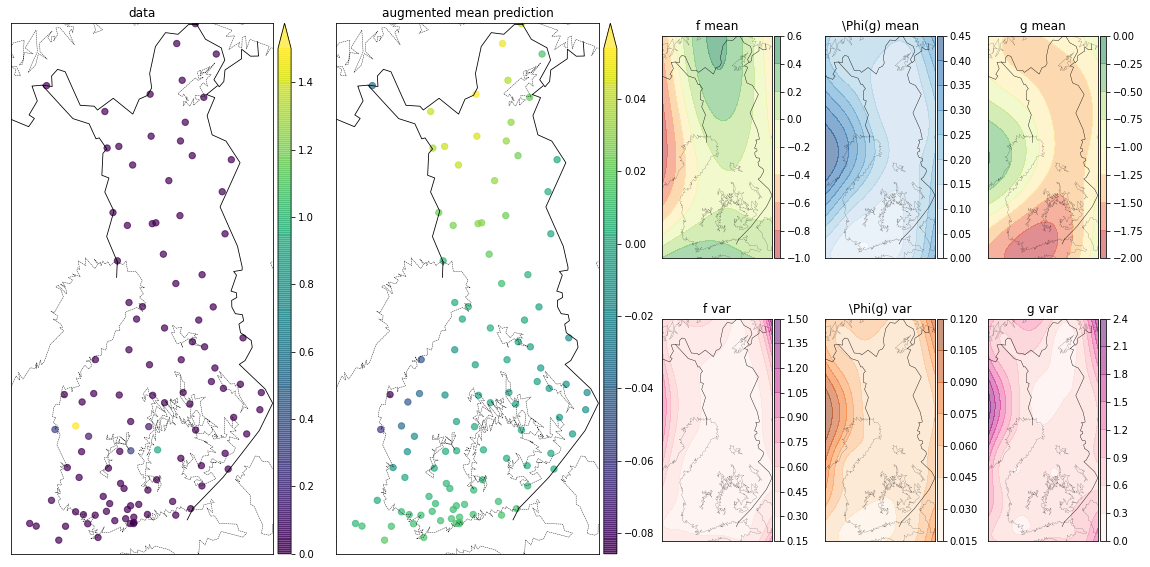

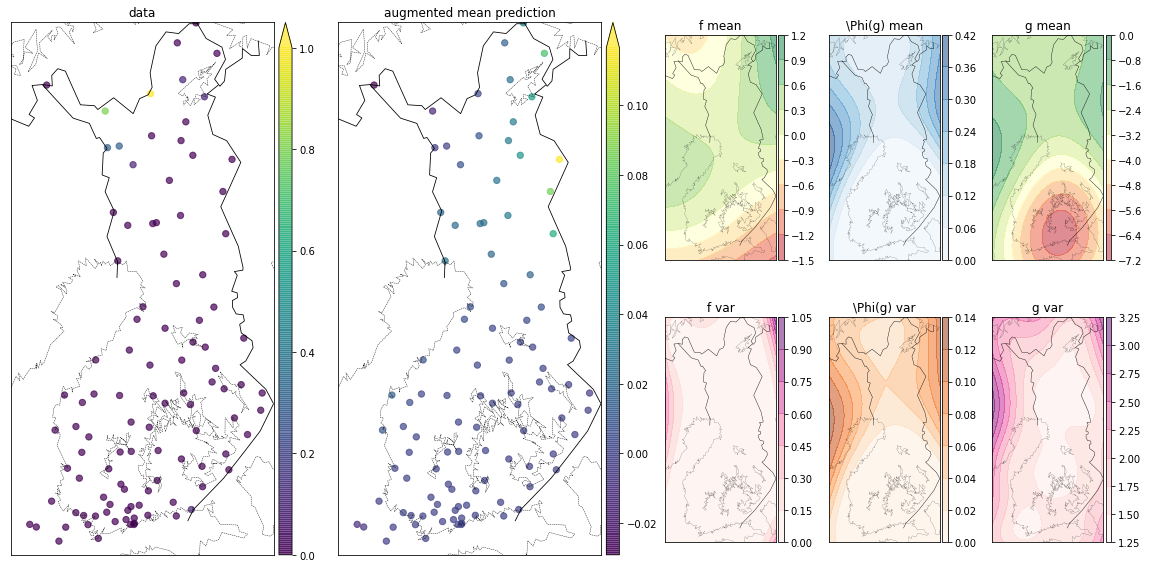

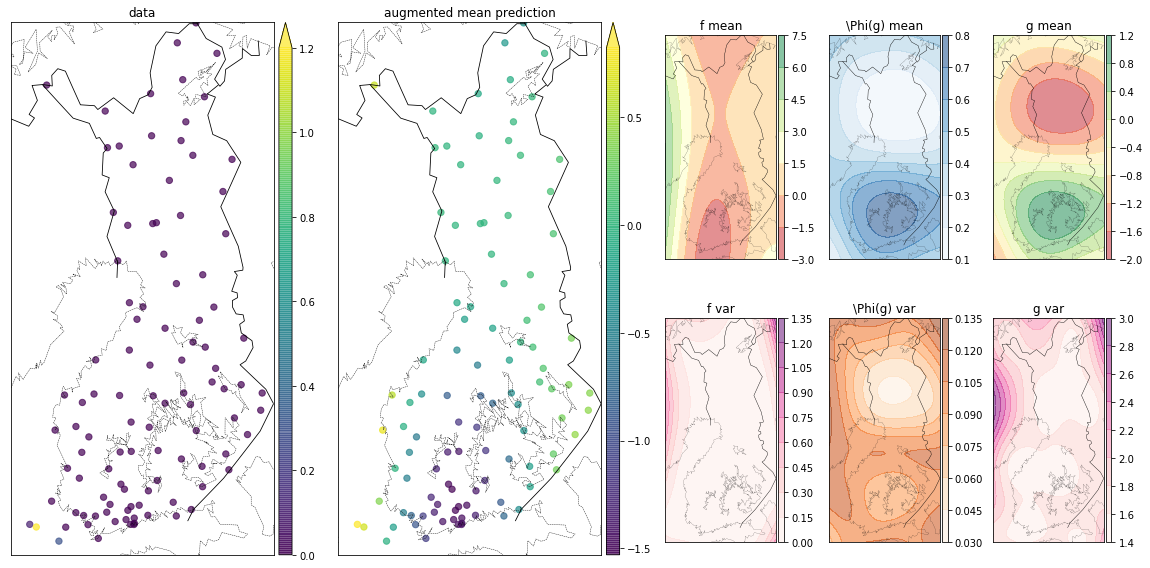

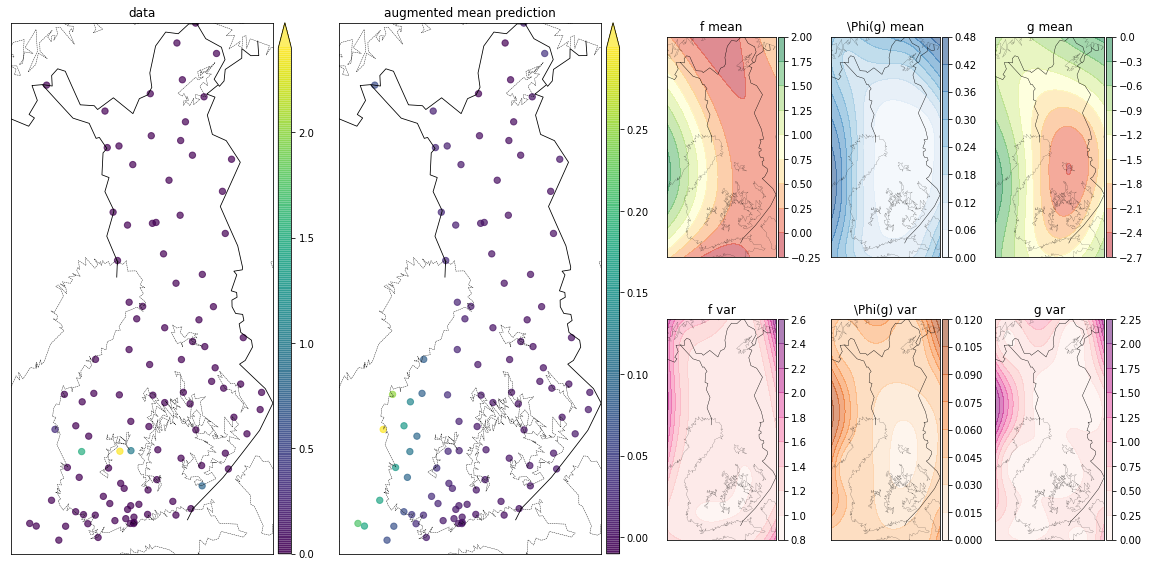

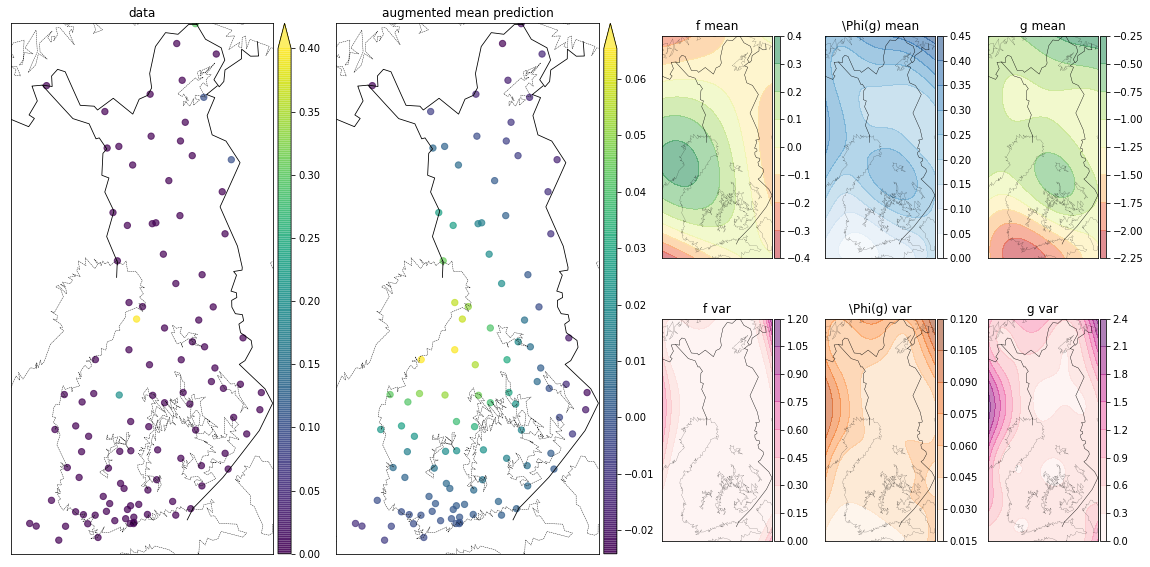

In [16]:
test_times = np.unique(Xtest[:,2])
np.random.shuffle(test_times)
for ttime in test_times[:5]:
    idx = Xtest[:,2] == ttime 
    _Xtest = Xtest.copy()[idx]
    _Ytest = Ytest.copy()[idx]

    plot_pptr(_Xtest,_Ytest,gfmean,gfmeanu,gfvar,fmean,fvar,gmean,gvar,ephi_g,evar_phi_g)

** train set visualizations **

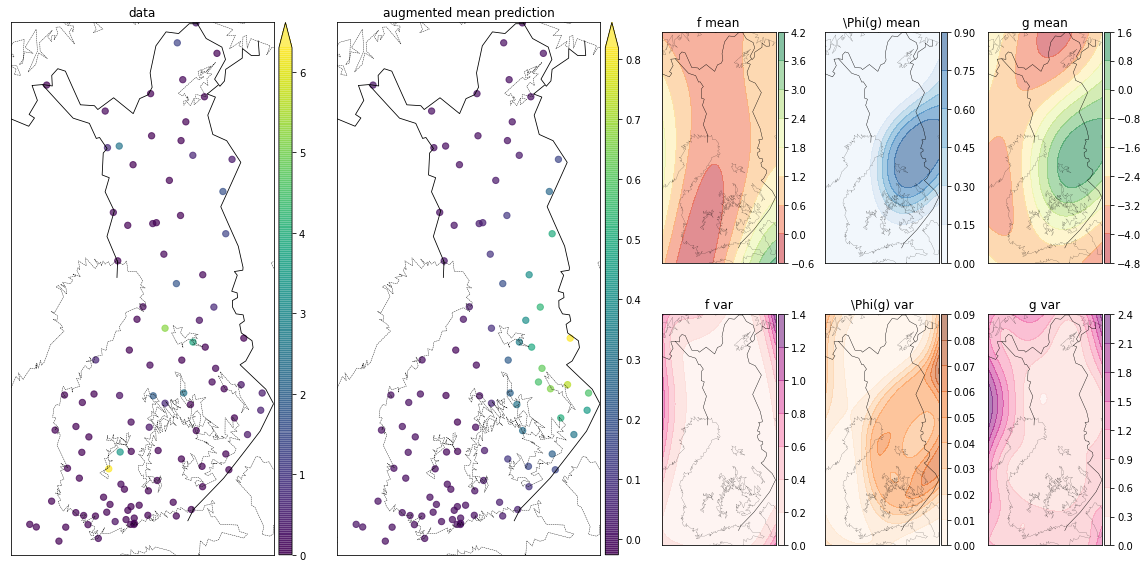

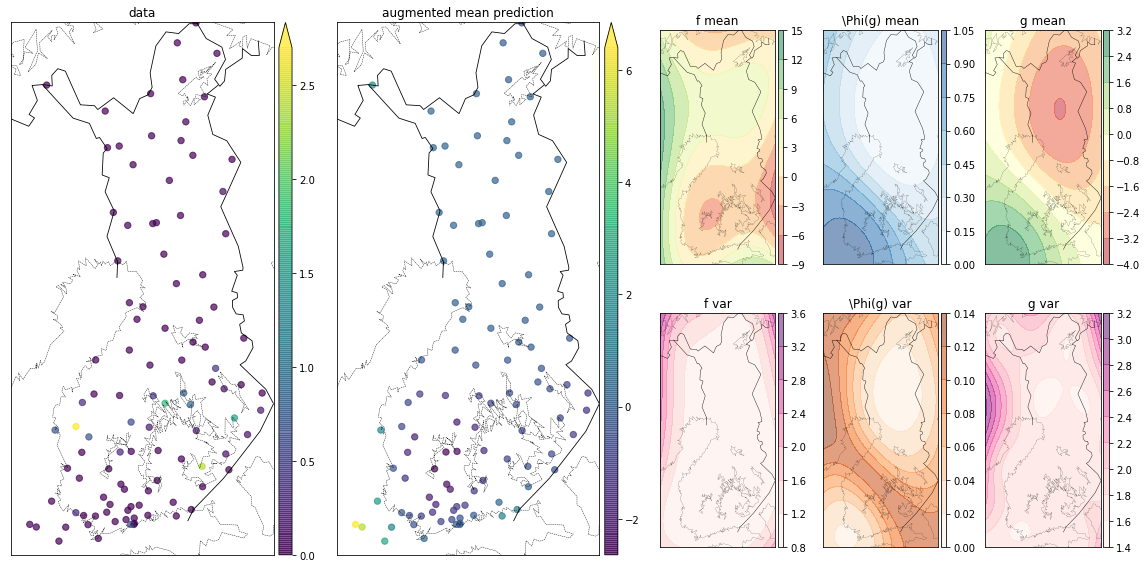

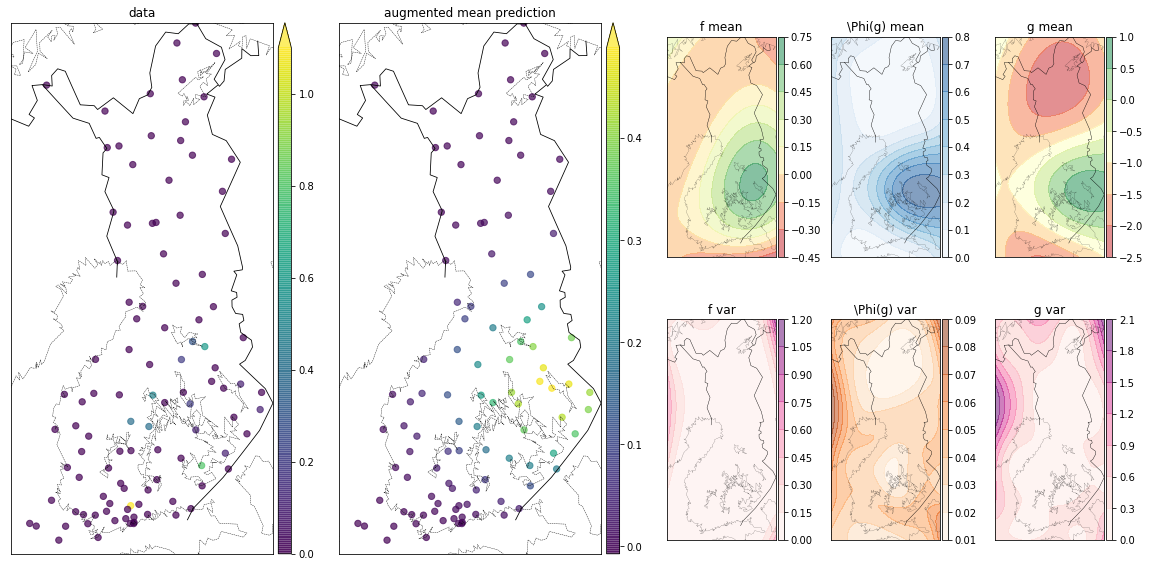

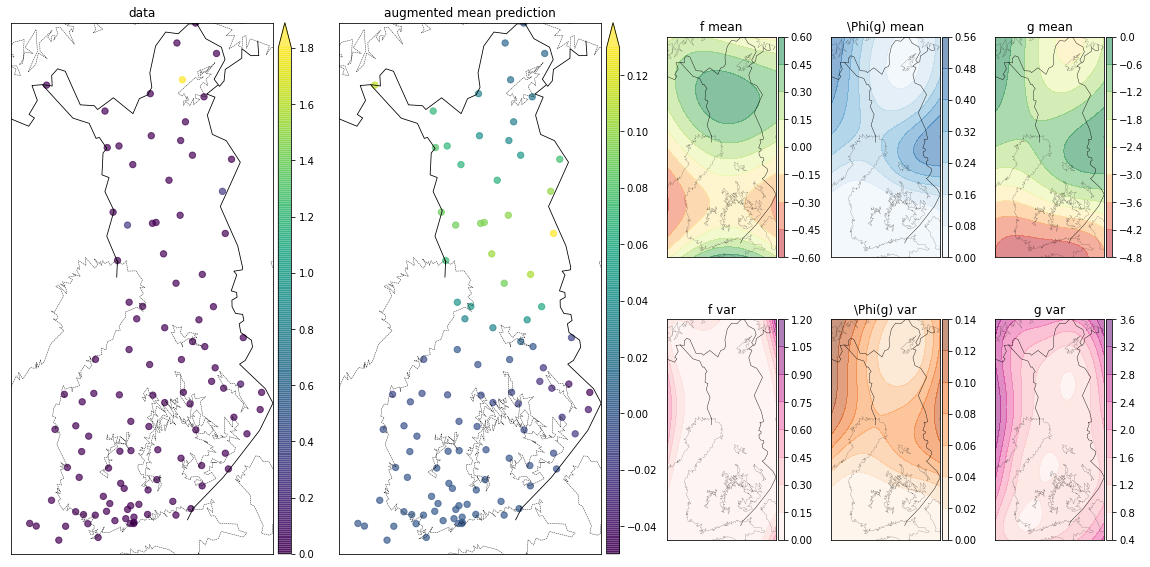

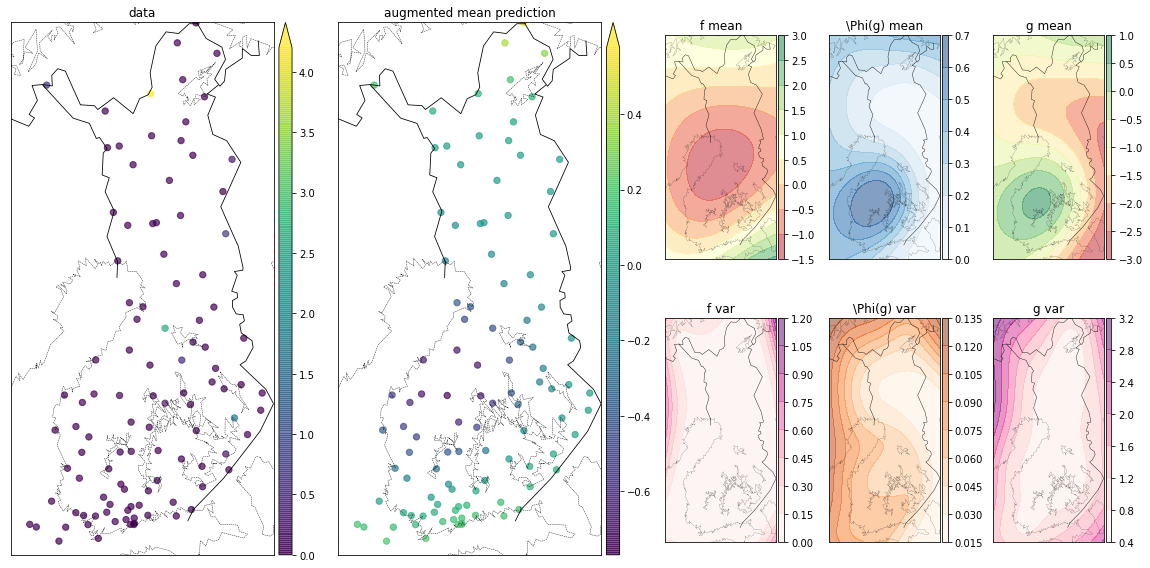

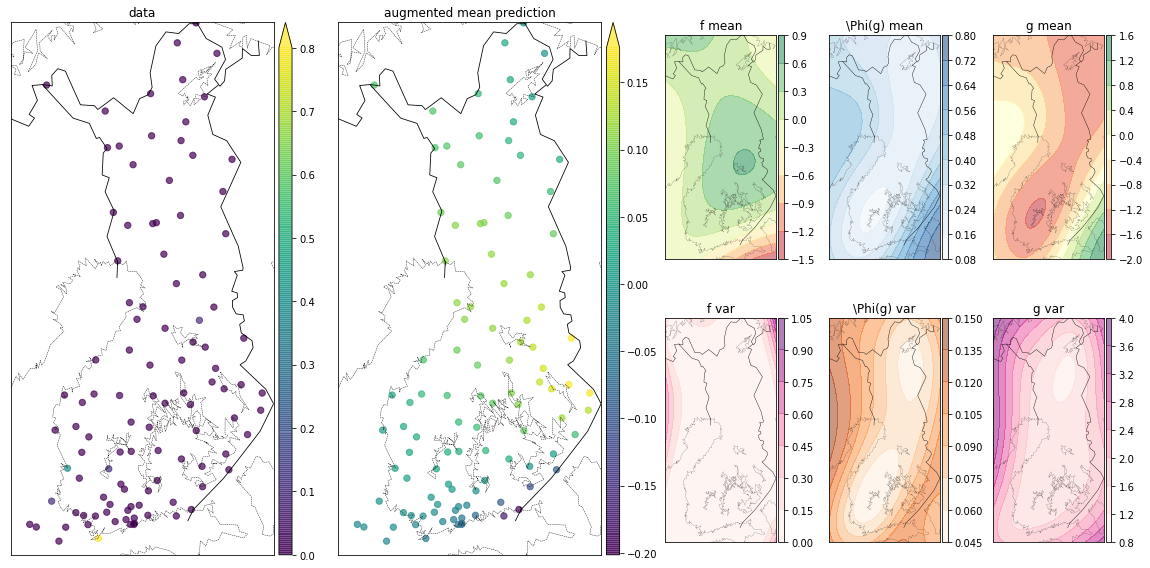

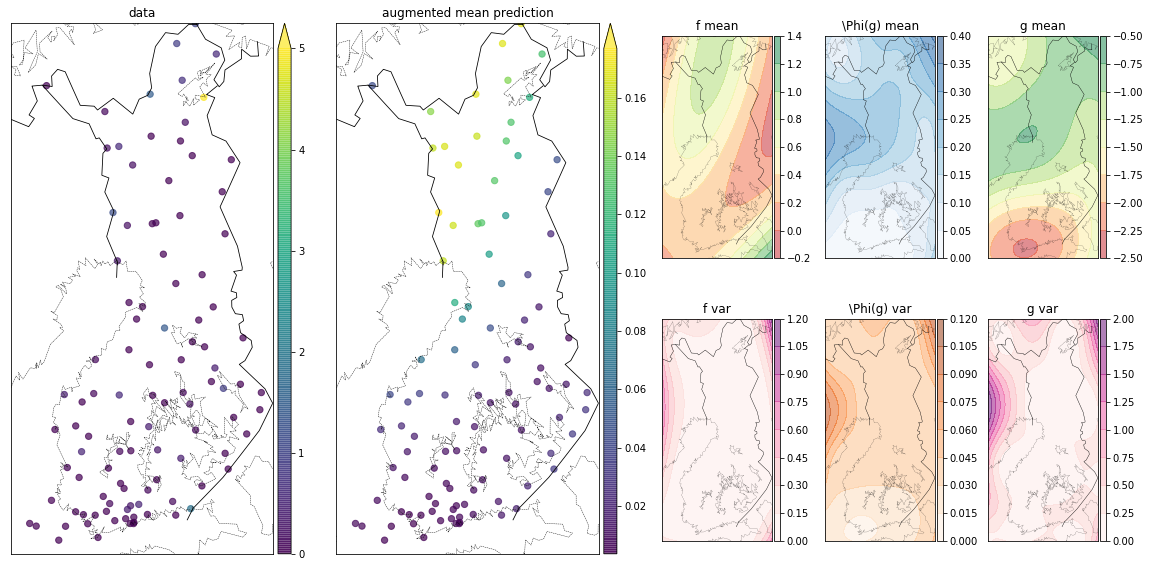

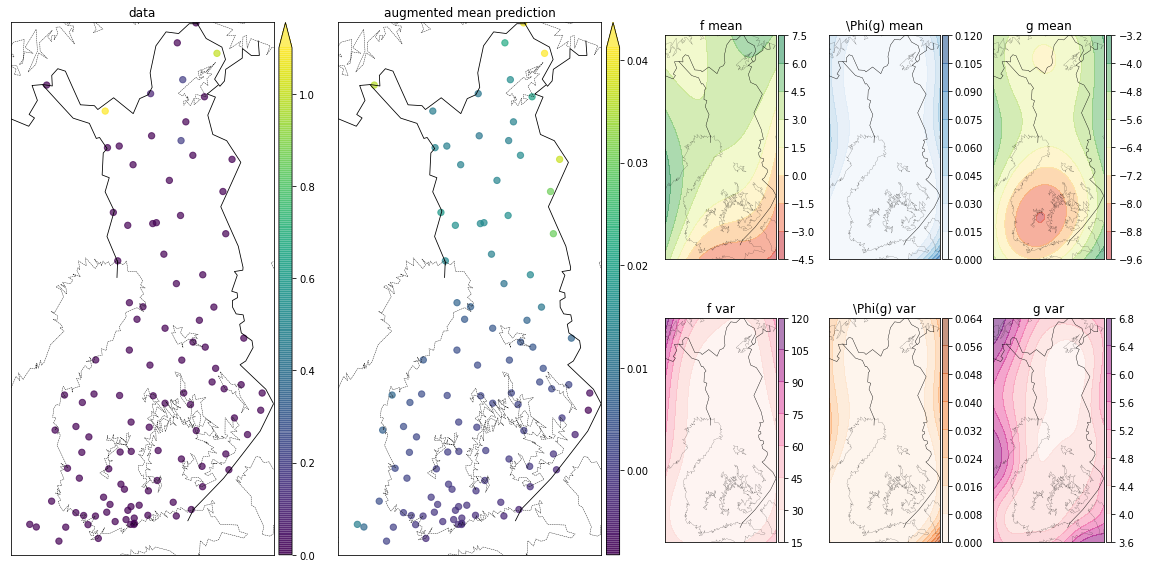

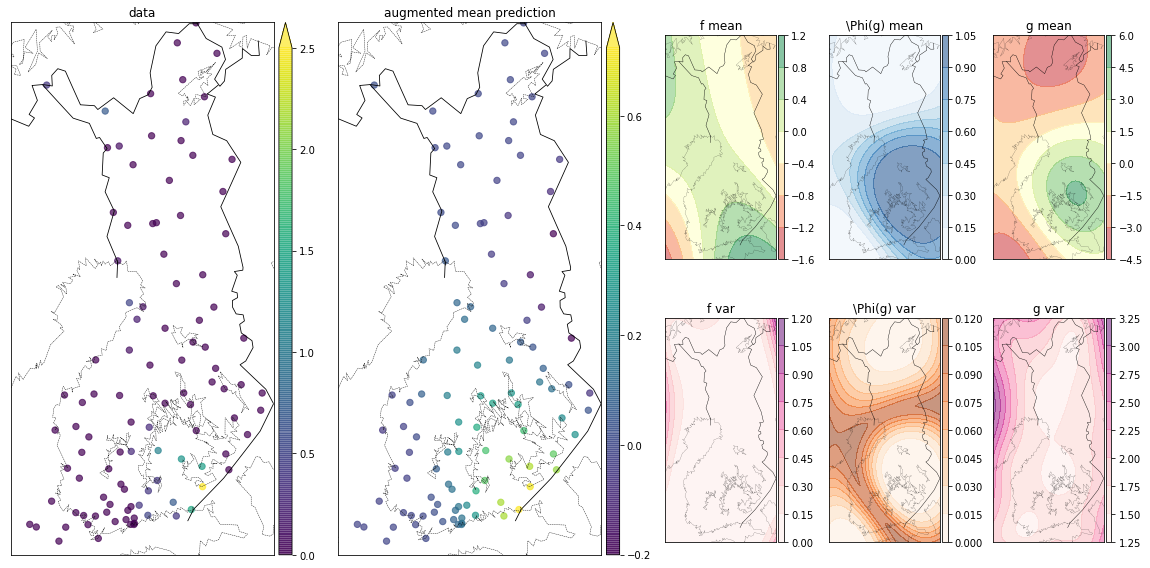

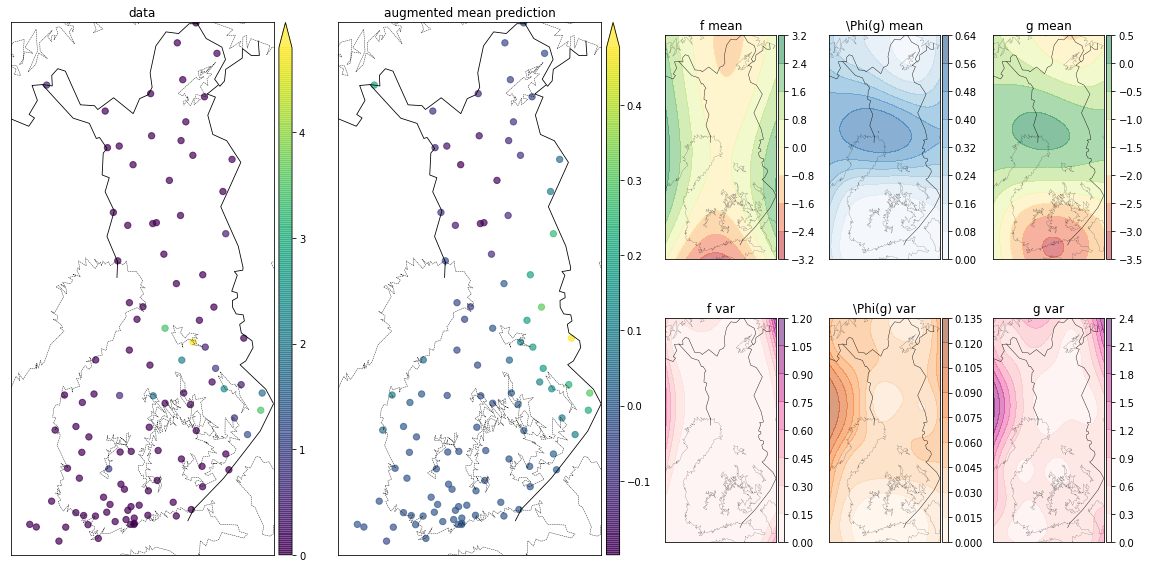

In [17]:
train_times = np.unique(Xtrain[:,2]) #np.arange(5200,5230,2.)
np.random.shuffle(train_times)
for ttime in train_times[:10]:
    idx = Xtrain[:,2] == ttime 
    _Xplot = Xtrain.copy()[idx]
    _Yplot = Ytrain.copy()[idx]
    plot_pptr(_Xplot,_Yplot,gfmean,gfmeanu,gfvar,fmean,fvar,gmean,gvar,ephi_g,evar_phi_g)